In [7]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

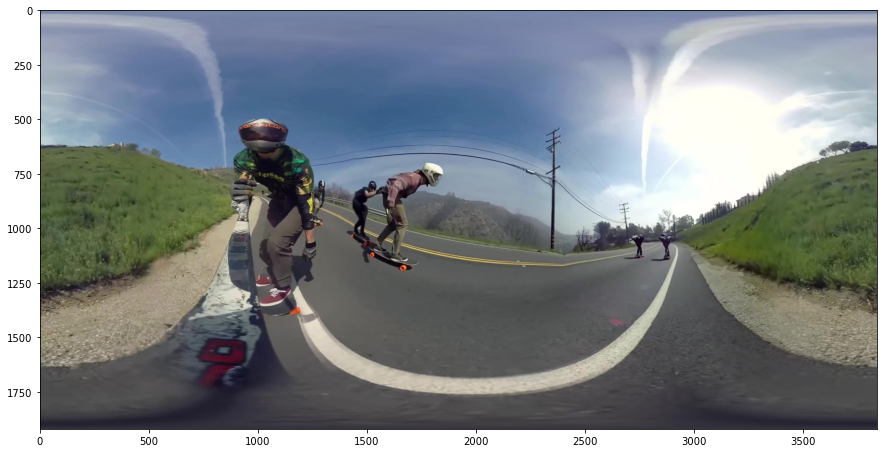

In [2]:
img = '/Users/aarsh/Desktop/CGVI/Thesis/Data/Test_3840x1920/0101/image/000010.jpg'
erp_img = cv2.imread(img)


plt.figure(figsize=(15, 15))
plt.imshow(erp_img[:, :, ::-1])
plt.show()

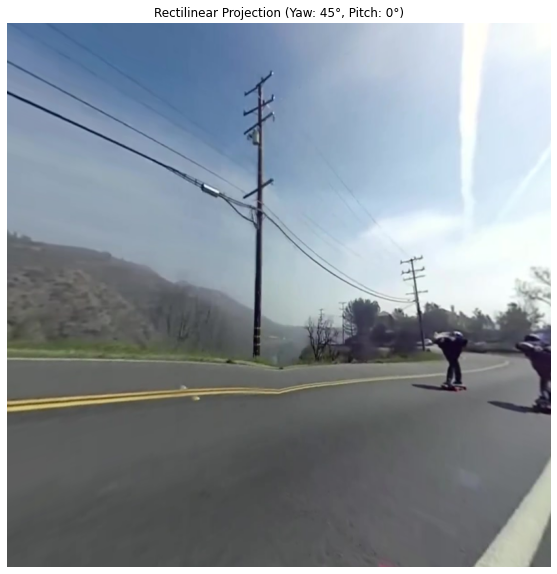

In [6]:
def erp_to_rectilinear(erp_image, fov_degrees, output_size, yaw_degrees=0, pitch_degrees=0):
    height, width, _ = erp_image.shape
    fov_radians = np.radians(fov_degrees)
    
    # Output dimensions
    out_height, out_width = output_size

    # Create a grid for the output image
    x, y = np.meshgrid(np.linspace(-1, 1, out_width), np.linspace(-1, 1, out_height))
    z = np.ones_like(x)

    # Convert grid to spherical coordinates
    xyz = np.stack([x, y, z], axis=-1)
    xyz /= np.linalg.norm(xyz, axis=-1, keepdims=True)

    # Adjust yaw and pitch
    yaw_radians = np.radians(yaw_degrees)
    pitch_radians = np.radians(pitch_degrees)
    rotation_matrix = np.array([
        [np.cos(yaw_radians), 0, np.sin(yaw_radians)],
        [0, 1, 0],
        [-np.sin(yaw_radians), 0, np.cos(yaw_radians)]
    ]) @ np.array([
        [1, 0, 0],
        [0, np.cos(pitch_radians), -np.sin(pitch_radians)],
        [0, np.sin(pitch_radians), np.cos(pitch_radians)]
    ])
    xyz = xyz @ rotation_matrix.T

    lon = np.arctan2(xyz[..., 0], xyz[..., 2])
    lat = np.arcsin(xyz[..., 1])

    # Map to ERP coordinates
    u = (lon / (2 * np.pi) + 0.5) * width
    v = (lat / np.pi + 0.5) * height

    # Remap the ERP image to the rectilinear projection
    rectilinear_image = cv2.remap(erp_image, u.astype(np.float32), v.astype(np.float32), interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_WRAP)

    return rectilinear_image[:, :, ::-1]


# Define field of view and output size
fov_degrees = 90
output_size = (800, 800)

# Set yaw and pitch angles
yaw_degrees = 45  # Horizontal angle
pitch_degrees = 0  # Vertical angle

# Convert to rectilinear projection with adjusted yaw and pitch
rectilinear_image = erp_to_rectilinear(erp_img, fov_degrees, output_size, yaw_degrees, pitch_degrees)

# Display the rectilinear projection
plt.figure(figsize=(10, 10))
plt.imshow(rectilinear_image)
plt.title(f'Rectilinear Projection (Yaw: {yaw_degrees}°, Pitch: {pitch_degrees}°)')
plt.axis('off')
plt.show()


By adjusting the yaw (horizontal angle), and pitch(vertical angle), we can look in different different directions within the 360 degree image.

To convert ERP image to a rectilinear projection, the process involves mapping the 2D ERP to a 3D sphere and then back to a 2D rectilinear image.

-  Create a grid of points that correspond to the pixel locations in the output rectilinear image. Each point in this grid represents a pixel in the output image.

- Combine `x`, `y`, and `z` to form 3D vectors. The `z` coordinate is set to 1 to represent a point on a unit sphere.

- Rotation Matrix: This matrix rotates the view direction based on the specified yaw and pitch angles.

- Convert the 3D cartesian coordinates to spherical coordinates (longitude and latitude)

- ERP coordinates: Map these spherical coordinates `u` and `v` coordinates in the ERP image.

- Remapping: The adjusted grid coordinates are used to remap the ERP, and create a rectilinear projection 

In [8]:
# Define interactive function
def update_view(yaw_degrees=0, pitch_degrees=0):
    rectilinear_image = erp_to_rectilinear(erp_img, fov_degrees, output_size, yaw_degrees, pitch_degrees)
    plt.figure(figsize=(10, 10))
    plt.imshow(rectilinear_image)
    plt.title(f'Rectilinear Projection (Yaw: {yaw_degrees}°, Pitch: {pitch_degrees}°)')
    plt.axis('off')
    plt.show()

# Create interactive widgets
yaw_slider = widgets.IntSlider(value=0, min=-180, max=180, step=1, description='Yaw:')
pitch_slider = widgets.IntSlider(value=0, min=-90, max=90, step=1, description='Pitch:')

# Display interactive widgets
widgets.interactive(update_view, yaw_degrees=yaw_slider, pitch_degrees=pitch_slider)


interactive(children=(IntSlider(value=0, description='Yaw:', max=180, min=-180), IntSlider(value=0, descriptio…